BigMart  Sales Data are 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

In [571]:

import pandas as pd
import numpy as np
%matplotlib inline
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 12, 8
import seaborn as sns
import matplotlib as plt


In [572]:
#Read files:
train = pd.read_csv("/Users/stellahrotich/Desktop/bigmart-sales-data/train.csv")
test = pd.read_csv("/Users/stellahrotich/Desktop/bigmart-sales-data/test.csv")

In [573]:
train['source']='train'
test['source']='test'
df = pd.concat([train, test],ignore_index=True)
print train.shape, test.shape, df.shape

(8523, 13) (5681, 12) (14204, 13)


/Applications/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  This is separate from the ipykernel package so we can avoid doing imports until


In [574]:
df.head(5)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


In [575]:
df.dtypes


Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
dtype: object

In [576]:
df.columns

Index([u'Item_Fat_Content', u'Item_Identifier', u'Item_MRP',
       u'Item_Outlet_Sales', u'Item_Type', u'Item_Visibility', u'Item_Weight',
       u'Outlet_Establishment_Year', u'Outlet_Identifier',
       u'Outlet_Location_Type', u'Outlet_Size', u'Outlet_Type', u'source'],
      dtype='object')

In [577]:
#check the missing values in train dataset
df.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

 Item_Weight and Item_Size has missing value and will need some data cleaning;Also the Item_Outlet_Sales because of the test data in the dataset which we are to predict.

Checking some basic statistics

In [578]:
df.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


Observations:
The test dataset does not have the Outlet Sales which we will have to predict by our model
Item_Visibility has a min value of zero. This makes no practical sense because when a product is being sold in a store, the visibility cannot be 0.
Outlet_Establishment_Years vary from 1985 to 2009. The values might not be apt in this form. Rather, if we can convert them to how old the particular store is, it should have a better impact on sales.
The lower ‘count’ of Item_Weight and Item_Outlet_Sales confirms the findings from the missing value check.

In [579]:
#checking unique values in each item
df.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [580]:
#checking unique values in each item
test.apply(lambda x: len(x.unique()))

Item_Identifier              1543
Item_Weight                   411
Item_Fat_Content                5
Item_Visibility              5277
Item_Type                      16
Item_MRP                     4402
Outlet_Identifier              10
Outlet_Establishment_Year       9
Outlet_Size                     4
Outlet_Location_Type            3
Outlet_Type                     4
source                          1
dtype: int64

In [581]:
#Filter categorical variables in the train dataset
categorical_columns = [x for x in df.dtypes.index if df.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories in the train dataset
for col in categorical_columns:
    print '\nFrequency of Categories for varible %s'%col
    print df[col].value_counts()


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

Data Cleaning

In [582]:

df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].mean())
df.head(10) 



,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.300000,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.920000,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.500000,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.200000,1998,OUT010,Tier 3,NaN,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.930000,1987,OUT013,Tier 3,High,Supermarket Type1,train
5,Regular,FDP36,51.4008,556.6088,Baking Goods,0.000000,10.395000,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
6,Regular,FDO10,57.6588,343.5528,Snack Foods,0.012741,13.650000,1987,OUT013,Tier 3,High,Supermarket Type1,train
7,Low Fat,FDP10,107.7622,4022.7636,Snack Foods,0.127470,12.792854,1985,OUT027,Tier 3,Medium,Supermarket Type3,train
8,Regular,FDH17,96.9726,1076.5986,Frozen Foods,0.016687,16.200000,2002,OUT045,Tier 2,NaN,Supermarket Type1,train
9,Regular,FDU28,187.8214,4710.5350,Frozen Foods,0.094450,19.200000,2007,OUT017,Tier 2,NaN,Supermarket Type1,train


In [583]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('missing')
df.head(10)





,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.300000,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.920000,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.500000,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.200000,1998,OUT010,Tier 3,missing,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.930000,1987,OUT013,Tier 3,High,Supermarket Type1,train
5,Regular,FDP36,51.4008,556.6088,Baking Goods,0.000000,10.395000,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
6,Regular,FDO10,57.6588,343.5528,Snack Foods,0.012741,13.650000,1987,OUT013,Tier 3,High,Supermarket Type1,train
7,Low Fat,FDP10,107.7622,4022.7636,Snack Foods,0.127470,12.792854,1985,OUT027,Tier 3,Medium,Supermarket Type3,train
8,Regular,FDH17,96.9726,1076.5986,Frozen Foods,0.016687,16.200000,2002,OUT045,Tier 2,missing,Supermarket Type1,train
9,Regular,FDU28,187.8214,4710.5350,Frozen Foods,0.094450,19.200000,2007,OUT017,Tier 2,missing,Supermarket Type1,train


In [584]:
df['Item_Weight'] = df['Item_Weight'].fillna((df['Item_Weight'].mean()))



In [585]:
#check the missing values in train dataset
df.apply(lambda x: sum(x.isnull()))



Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64

Missing Values is now well taken care of:Great!Lets move on now,the remaining missing values are the Item_Outleet_Sales from the test Data that will be taken care of by the model.

In [586]:
#check if there is any more missing values in  dataset
df.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                     0
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                     0
Outlet_Type                     0
source                          0
dtype: int64

In [587]:
#check the results after data cleaning
df.head(5)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,missing,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.000000,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train


Its only the sales remaining that weill be filled up by prediction models later

 Feature Engineering

BigMart has to understand the properties of products and stores which play a key role in increasing sales.
One noticable feature is the minimum value for Item_Visibility is 0, which does not make sense  thus we can replace it with the mean of the feature.

In [588]:
#replacing the Item_Visibility value 0 with mean

df['Item_Visibility'] = df['Item_Visibility'].replace(0,df['Item_Visibility'].mean())




In [589]:
#check the data if ih has been replaced correctly and has no 0 values now
df.head(10)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.300000,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.920000,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.500000,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.065953,19.200000,1998,OUT010,Tier 3,missing,Grocery Store,train
4,Low Fat,NCD19,53.8614,994.7052,Household,0.065953,8.930000,1987,OUT013,Tier 3,High,Supermarket Type1,train
5,Regular,FDP36,51.4008,556.6088,Baking Goods,0.065953,10.395000,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
6,Regular,FDO10,57.6588,343.5528,Snack Foods,0.012741,13.650000,1987,OUT013,Tier 3,High,Supermarket Type1,train
7,Low Fat,FDP10,107.7622,4022.7636,Snack Foods,0.127470,12.792854,1985,OUT027,Tier 3,Medium,Supermarket Type3,train
8,Regular,FDH17,96.9726,1076.5986,Frozen Foods,0.016687,16.200000,2002,OUT045,Tier 2,missing,Supermarket Type1,train
9,Regular,FDU28,187.8214,4710.5350,Frozen Foods,0.094450,19.200000,2007,OUT017,Tier 2,missing,Supermarket Type1,train


Create a broad category of Type of Item

In [590]:

df['Item_Type_Combined'] = df['Item_Identifier'].apply(lambda x: x[0:2])

df['Item_Type_Combined'] = df['Item_Type_Combined'].map({'FD':'Food',
                                                        'NC':'Non-Consumable',
                                                        'DR':'Drinks'})
df['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

Determine the years of operation of a store

In [591]:
#Change categories of low fat:
print 'Original Fat Categories:'
print df['Item_Fat_Content'].value_counts()

print '\nModified Categories:'
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print df['Item_Fat_Content'].value_counts()

Original Fat Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [592]:

df['Outlet_Years'] = 2013 - df['Outlet_Establishment_Year']
df['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

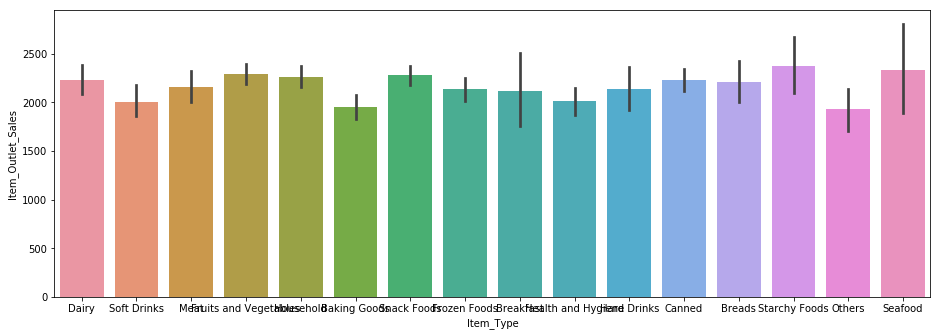

In [598]:

#sns.countplot(y = 'Item_Type', data = df)
#sns.despine()
import matplotlib.pyplot as plt
a4_dims = (15.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot( ax=ax,x = "Item_Type", y = "Item_Outlet_Sales" , data = df)

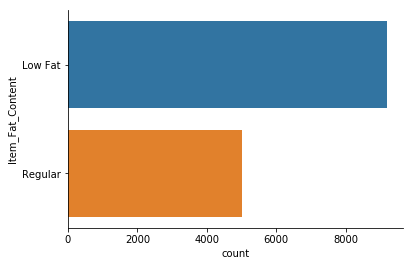

In [537]:
sns.countplot(y="Item_Fat_Content", data=df)
sns.despine()

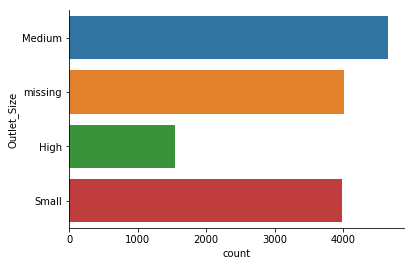

In [538]:

sns.countplot(y="Outlet_Size", data=df)
sns.despine()





Stores which are large are very few in number


Modify categories of Item_Fat_Content

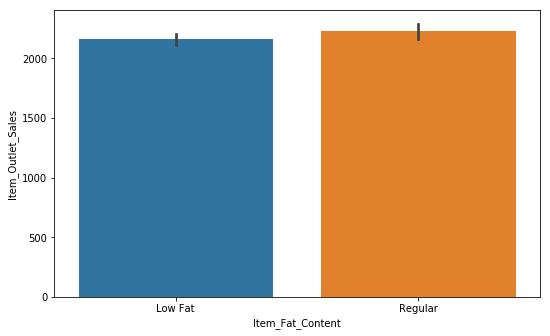

In [601]:

#sns.countplot(y = 'Item_Type', data = df)
#sns.despine()
import matplotlib.pyplot as plt
a4_dims = (8.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot( ax=ax,x = "Item_Fat_Content", y = "Item_Outlet_Sales" , data = df)

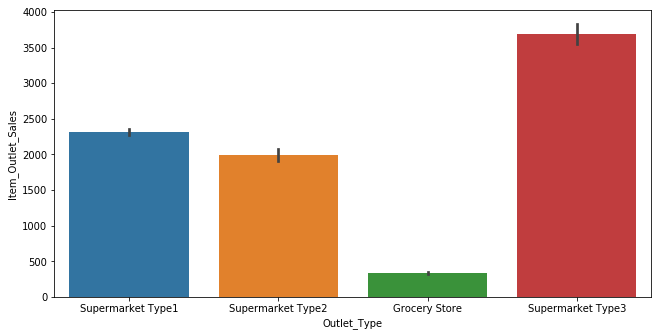

In [608]:
#sns.countplot(y = 'Outlet_Type', data = df)
#sns.despine()
import matplotlib.pyplot as plt
a4_dims = (10.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot( ax=ax,x = "Outlet_Type", y = "Item_Outlet_Sales" , data = df)

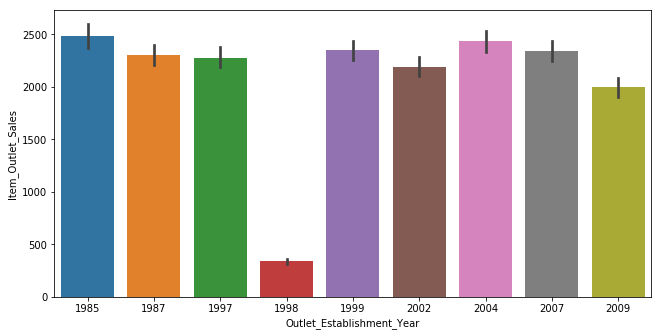

In [607]:
import matplotlib.pyplot as plt
a4_dims = (10.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot( ax=ax,x = "Outlet_Establishment_Year", y = "Item_Outlet_Sales" , data = df)
#sns.countplot(y = 'Outlet_Establishment_Year', data = df)
#sns.despine()

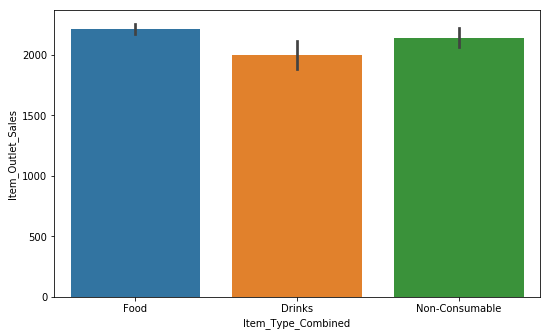

In [569]:

#sns.countplot(y = 'Item_Type', data = df)
#sns.despine()
import matplotlib.pyplot as plt
a4_dims = (8.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot( ax=ax,x = "Item_Type_Combined", y = "Item_Outlet_Sales" , data = df)

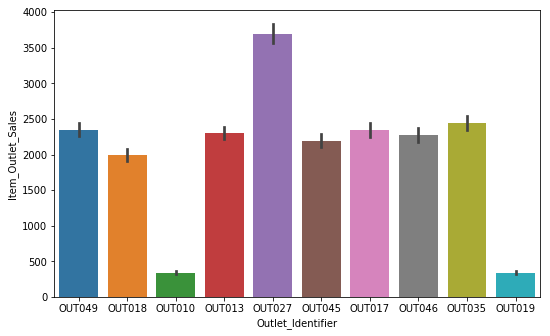

In [543]:
import matplotlib.pyplot as plt
a4_dims = (8.7, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot( ax=ax,x = "Outlet_Identifier", y = "Item_Outlet_Sales" , data = df)

In [544]:
df.corr()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Years
Item_MRP,1.000000,0.567574,-0.008790,0.033002,0.000141,-0.000141
Item_Outlet_Sales,0.567574,1.000000,-0.134141,0.011083,-0.049135,0.049135
Item_Visibility,-0.008790,-0.134141,1.000000,-0.015313,-0.088598,0.088598
Item_Weight,0.033002,0.011083,-0.015313,1.000000,0.000462,-0.000462
Outlet_Establishment_Year,0.000141,-0.049135,-0.088598,0.000462,1.000000,-1.000000
Outlet_Years,-0.000141,0.049135,0.088598,-0.000462,-1.000000,1.000000


In [545]:
df.head(5)


,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train,Drinks,4
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train,Food,14
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.065953,19.20,1998,OUT010,Tier 3,missing,Grocery Store,train,Food,15
4,Low Fat,NCD19,53.8614,994.7052,Household,0.065953,8.93,1987,OUT013,Tier 3,High,Supermarket Type1,train,Non-Consumable,26


In [546]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

li = ['Outlet_Type','Outlet_Location_Type','Outlet_Size','Item_Fat_Content','Outlet_Identifier']
for i in li:
    df[i] = le.fit_transform(df[i])
    
df.head(5)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source,Item_Type_Combined,Outlet_Years
0,0,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,9,0,1,1,train,Food,14
1,1,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,3,2,1,2,train,Drinks,4
2,0,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,9,0,1,1,train,Food,14
3,1,FDX07,182.0950,732.3800,Fruits and Vegetables,0.065953,19.20,1998,0,2,3,0,train,Food,15
4,0,NCD19,53.8614,994.7052,Household,0.065953,8.93,1987,1,2,0,1,train,Non-Consumable,26


In [547]:
df.dtypes


Item_Fat_Content               int64
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier              int64
Outlet_Location_Type           int64
Outlet_Size                    int64
Outlet_Type                    int64
source                        object
Item_Type_Combined            object
Outlet_Years                   int64
dtype: object

In [548]:
#Drop the columns which have been converted to different types:
df.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = df.loc[df['source']=="train"]
test = df.loc[df['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)


In [556]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("alg0.csv",index=False)



/Applications/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [555]:
#Define target and ID columns:
Target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print "\nModel Report"
    print "RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions))
    print "CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv(filename, index=False)

In [551]:
train.columns


Index([u'Item_Fat_Content', u'Item_Identifier', u'Item_MRP',
       u'Item_Outlet_Sales', u'Item_Visibility', u'Item_Weight',
       u'Outlet_Identifier', u'Outlet_Location_Type', u'Outlet_Size',
       u'Outlet_Type', u'Item_Type_Combined', u'Outlet_Years'],
      dtype='object')

In [565]:
test.columns

Index([u'Item_Fat_Content', u'Item_Identifier', u'Item_MRP',
       u'Item_Visibility', u'Item_Weight', u'Outlet_Identifier',
       u'Outlet_Location_Type', u'Outlet_Size', u'Outlet_Type',
       u'Item_Type_Combined', u'Outlet_Years'],
      dtype='object')

In [566]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

ValueError: could not convert string to float: Drinks

In [567]:

df["Item_Type_Combined"].astype("float")


ValueError: could not convert string to float: Food

Base Model

Decision Tree Model

Random Forest Model

DONE!